## Exploratory Data Analysis

Questions to answer:
- What are the proportions of real student outcomes?
- What are student's beliefs in their educational attainment?
- What is the distribution of math scores?
- What are some common problems at the schools, and what do Principals think of them?
- Are there any interesting variables that can be tracked over all four survey points?


A major component of answering quantitative questions with this data set is the use of weights and replicate weights to convert the given data to data that is representative of the population. The data set is collected using complex sampling, meaning that each student in the US is not equally likely to be selected for the study. 

The sample was constructed so that major groups of interest, like public/private schools or students from different socio-economic backgrounds, were all represented within the study while minimizing the resource to implement the study. In addition, some schools selected, and students within the selected schools, did not participate in the study. To account for these effects, weights are provided within the data set to convert raw statistics into statistics that are representative of the US population.

For each group of respondents, such as students or school counselors, and each collection timeframe, a weight is given for caclulating statistics such as a mean, that should multiply the contribution of each student record. Similarly, for each group of student respondents and each collection timeframe, a group of 200 replicate weights is given to calculate the variance. The statistic is calculated 200 times with the varying sets of weights, and so the variance of the statistic can be accurately stated. 

Without including weights, statistics and variance in those statistics would be subject to large biases due to over-representation of certain groups in the sample and non-response bias.

In [1]:
#load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Import data set from last notebook
filepath = '/Users/chrismalec/DS_Portfolio/CapstoneProjectOne/'
studentdatafile = 'HSLS_2016_v1_0_CSV_Datasets/hsls_16_student_v1_0.csv'

df_BY = pd.read_pickle(filepath + 'df_BY.pkl')
df_F1 = pd.read_pickle(filepath + 'df_F1.pkl')
df_F2 = pd.read_pickle(filepath + 'df_F2.pkl')
df_F3 = pd.read_pickle(filepath + 'df_F3.pkl')
df_weights = pd.read_pickle(filepath+'df_weights.pkl')

In [2]:
import pickle
pickle_in = open(filepath+'number_labels.pkl',"rb")
number_labels = pickle.load(pickle_in)

In [3]:
#Example for column X1TXMTH: Mathematics theta score, first with no weight
avg_theta_score = (df_BY['X1TXMTH']).mean()
a_weight = df_weights['W1MATHTCH']
sum_aweight = a_weight.sum()
estimate = df_BY['X1TXMTH'].multiply(a_weight).sum()

print('Without weights, the average is ',round(avg_theta_score,3),
      ' while with weights the average is ',round(estimate/sum_aweight,3))

Without weights, the average is  -0.669  while with weights the average is  -0.05


I would like to avoid writing this code over and over again, and calculating the variance using replicate weights is even another step. There are two distinct actions I will probably have to take, one to calculate a statistic from numeric data, and one to sum counts for categorical data. The following two functions estimate a statistic or a count for a particular column of data.

In [4]:
def estimate_statistic(column,df_data,weight,df_weight,func = np.sum,normalize = False):
    replicate_weight_list = [weight +'{:03d}'.format(x) for x in range(1,201)]
    analytic_weight = df_weight[weight]
    replicate_weights = df_weight[replicate_weight_list]
    sum_analytic_weight = analytic_weight.sum()
    if(normalize == False):
        sum_analytic_weight = 1
        
    estimate = func(df_data[column].multiply(analytic_weight))/sum_analytic_weight
    
    replicate_estimates = np.empty(len(replicate_weight_list))
    for i,w in enumerate(replicate_weights.columns):
        replicate_estimate = func(df_data[column].multiply(replicate_weights[w]))/sum_analytic_weight
        replicate_estimates[i] = replicate_estimate
    
    variance = ((replicate_estimates - estimate)**2).sum()/(len(replicate_weight_list)-1)
    stdev = np.sqrt(variance)
    return (estimate, stdev)

In [5]:
def estimate_count(column,df_data,weight,df_weight,code_dict):
    replicate_weight_list = [weight +'{:03d}'.format(x) for x in range(1,201)]
    df_agg = pd.concat([df_data[column].astype('int64',errors = 'ignore'),df_weight[[weight]+replicate_weight_list]],axis=1)
    df_agg = df_agg.groupby(column).sum()
    df_estimate_variance = pd.DataFrame(data={'category':[],'estimate':[],'std dev':[]})
    #For some reason, some numeric variable labels are floats instead of integers, may fix this is cleaning stage.
    for i, row in df_agg.iterrows():
        #double check std estimation here
        df_estimate_variance.loc[i] = [code_dict[str(round(i))],
                                       df_agg.loc[i,weight],
                                       df_agg.loc[i,replicate_weight_list].std()]
    
    return df_estimate_variance

## What are the real student outcomes?

The labels for this data set come from the second followup/transcript collection phase of the study since this is the most comprehensive and reliable information. The good news is that most students graduate high school, however it makes the other categories difficult to see, so a graph with 'Fall 2012 - Summer 2013 graduate' and 'Status cannot be determined' removed is also shown. We can see that 'dropped out' is only about 20,000 students of over 4 million. 'Graduation date unknown' and 'Status cannot be determined' merit further investigation.

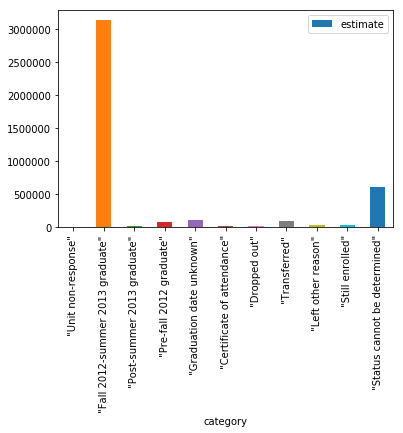

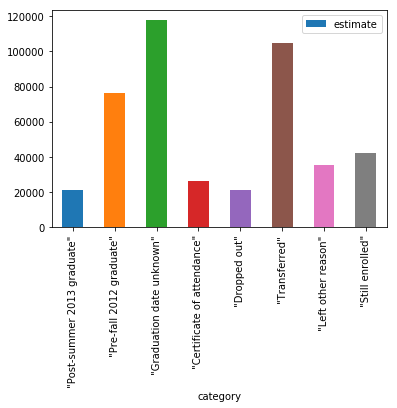

In [6]:
#What are the proportions of real student outcomes?
df_temp = estimate_count('X3TOUTCOME',df_F2,'W3STUDENTTR',df_weights,number_labels['X3TOUTCOME'])
df_temp.plot.bar(x='category',y='estimate')
keep_cats = [2,3,4,5,6,7,8,9]
df_temp.iloc[keep_cats,:].plot.bar(x='category',y='estimate')


## What do students believe their educational attainment will be?

Belief is a powerful thing. Believing you will succeed is not sufficient to success, but it is necessary. Here we see that the number of students who believe that they will complete 'less than high school' is tiny, much smaller than the 'dropped out' count. A great number are under 'don't know', which is a reasonable response for someone who is 14-15. This says to me that students generally do not plan on dropping out.

I also see that most people really believe in their own follow-through, as 'start a(n) X degree' are all much lower counts than 'finish a(n) X degree'.

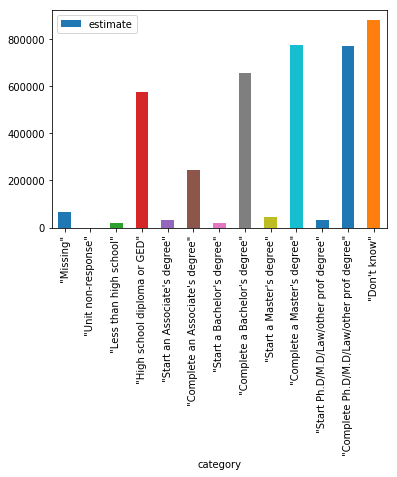

In [7]:
#What are student's beliefs in their educational attainment?
df_temp = estimate_count('S1EDUEXPECT',df_BY,'W1STUDENT',df_weights,number_labels['S1EDUEXPECT'])
df_temp.plot.bar(x='category',y='estimate')

## What is the distribution of mathematics scores

In my personal experience, math can be a breaking point for a lot of students, and achievement gaps are wider than for other subjects. This particular study collected information about math and science classes and teachers, so I wanted to look at some aspect of this data. The standardized theta score presented here is supposed to present some measure of a student's math level.

To see a distribution, I have to weight the data at the level of the histogram, so that a particular score is given the correct count.

From the graph, I can see that this particular measure is calibrated so that '0' represents a fairly average math student. It is not a normal distribution, however the variations in math scores on this scale are smooth, with many students represented at every level. Still, trying to work with students coming from many levels is a challenge for teachers in any subject.

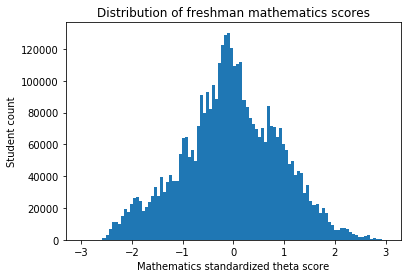

In [8]:
scores = df_BY['X1TXMTH']
weights = df_weights['W1MATHTCH']
_ = plt.hist(scores, bins = 100, weights=weights,range = (-3,3))
_ = plt.xlabel('Mathematics standardized theta score')
_ = plt.ylabel('Student count')
_ = plt.title('Distribution of freshman mathematics scores')
plt.show()

## What does administration think about problems at the school?

Leadership matters, and I was curious about what administration thinks the biggest problems at various schools are. I think in this case the 'school' data table may be more appropriate, as this only includes one admin response for each school. Because of how the data is anonymized, I cannot aggregate by school for the student level data. These responses therefore represent student experience more than proportion of admins with various beliefs. This means that if one admin believes that tardiness is not a problem, but an admin at another school that has 10x more students believes tardiness is a problem, this means that 10x more students attend a school where administration believes tardiness is a problem.

In [9]:
#What are some common problems at the schools, and what do Principals think of them?
#Create a list of variable names where 'is a problem' is in the description, I only chose the admin's opinion here.
problem_desc = []
problem_labels = []
for key, value in number_labels.items():
    if 'desc' in value.keys():
        if ('is a problem' in value['desc']) & (key[0:2] == 'A1'):
            if value['desc'][8:] not in problem_desc:
                problem_desc.append(value['desc'][8:])
            if key[0] == 'A':
                problem_labels.append(key)

print('Some possible problems include:')
for problem in problem_desc:
    print(problem)

Some possible problems include:
Student tardiness is a problem at this school
Teacher absenteeism is a problem at this school
Student apathy is a problem at this school
Lack of parental involvement is a problem at this school
Students coming unprepared to learn is a problem at this school
Poor student health is a problem at this school
Lack of teacher resources and materials is a problem at this school


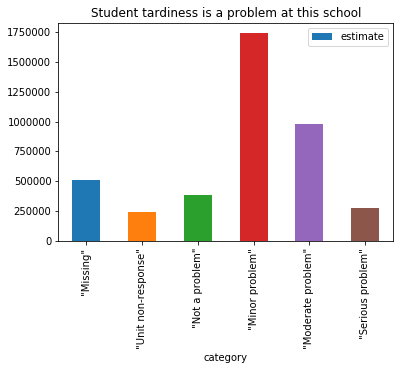

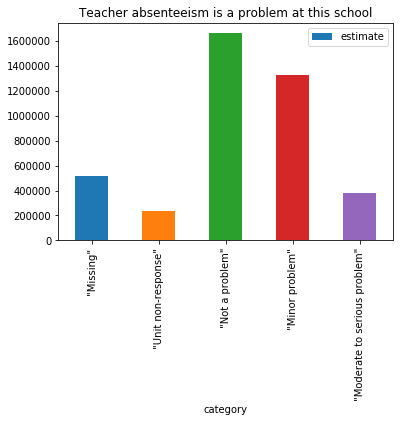

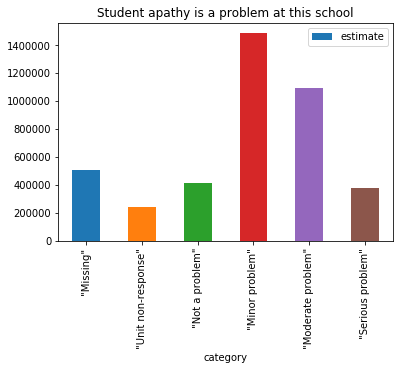

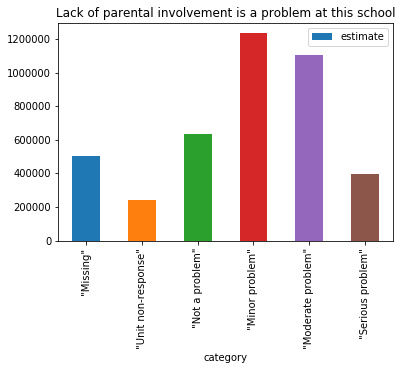

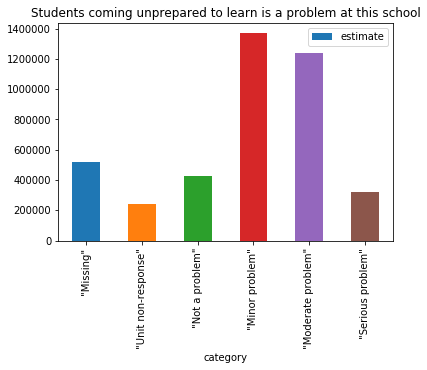

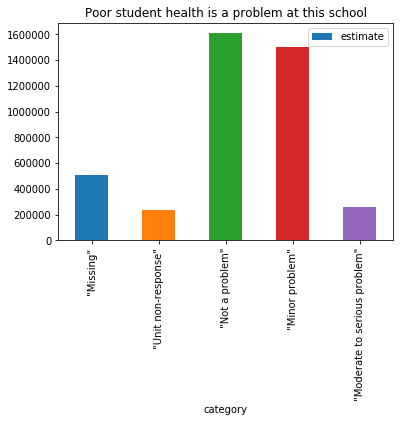

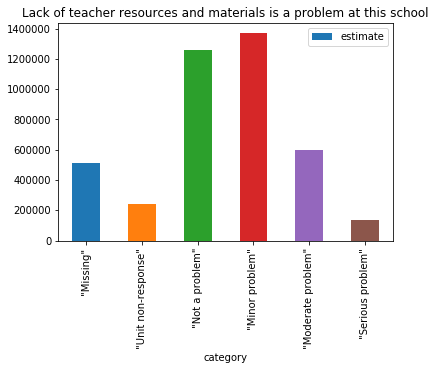

In [10]:
#Create a series of bar graphs, this would be a good one to create a more information dense graph.
for problem in problem_labels:
    df_temp = estimate_count(problem,df_BY,'W1STUDENT',df_weights,number_labels[problem])
    df_temp.plot.bar(x='category',y='estimate',title=number_labels[problem]['desc'][8:])

## Are there any interesting variables that span multiple years in the study?

I would like to know which variables measure the same thing over multiple years. It turns out that only very generic information such as 'locale' of the student is carried across all four collection times. There are a number of interesting variables that were collected in all followups, including whether or not a student has ever dropped out.

In [11]:
#Take advantage of set operations to make comparisons easy
Long_var = dict({'1':set(),'2':set(),'3':set(),'4':set()})
for key,value in number_labels.items():
    temp = list(key)
    time = temp.pop(1)
    if time not in Long_var.keys():
        continue
    Long_var[time].add(''.join(temp))

Long_var_14 = Long_var['1'].intersection(Long_var['2'],Long_var['3'],Long_var['4'])
Long_var_24 = Long_var['2'].intersection(Long_var['3'],Long_var['4'])
Long_var_12 = Long_var['1'].intersection(Long_var['2'])
print('Variables carried across all four collection times:')
for item in Long_var_14:
    orig_key = item[0]+'1'+item[1:]
    print(number_labels[orig_key]['desc'])
print('')

print('Variables carried across all three followup collection times:')
for item in Long_var_24:
    orig_key = item[0]+'2'+item[1:]
    print(number_labels[orig_key]['desc'])
print('')

print('Variables carried across base year (freshman) and first followup (junior):')
for item in Long_var_12:
    orig_key = item[0]+'1'+item[1:]
    if 'desc' in number_labels[orig_key].keys():
        print(number_labels[orig_key]['desc'])
print('')

Variables carried across all four collection times:
X1 School locale (urbanicity)
X1 School control
X1 School geographic region
X1 Student questionnaire date (YYYYMM)
X1 Student questionnaire status

Variables carried across all three followup collection times:
S2 A06B Year teenager received diploma/GED/alternative credential
X2 School locale (urbanicity)
S2 A07B Year teenager last attended high school
X2 School control
S2 C26A Importance of academic quality/reputation when choosing college/school
X2 Ever dropout
X2 School geographic region
S2 A05 Teenager has earned a high school credential
S2 C26B Importance of cost of attendance when choosing college/school
X2 Sample member status in BY and F1 rounds
X2 Student questionnaire date (YYYYMM)
X2 Student questionnaire status

Variables carried across base year (freshman) and first followup (junior):
X1 Mathematics proficiency probability score: level 2
A1 C06 Ease of filling high school science teaching vacancies
P1 F22 Family has opened

In [12]:
#Take a closer look at the 'ever dropped out' variable across years in the study.

df_temp1 = estimate_count('X2EVERDROP',df_F1,'W2STUDENT',df_weights,number_labels['X2EVERDROP'])
df_temp2 = estimate_count('X3EVERDROP',df_F2,'W3STUDENT',df_weights,number_labels['X3EVERDROP'])
df_temp3 = estimate_count('X4EVERDROP',df_F3,'W4STUDENT',df_weights,number_labels['X4EVERDROP'])

In [13]:
x = ['2012','2013','2016']
y = [df_temp1.loc[1,'estimate'],df_temp2.loc[1,'estimate'],df_temp3.loc[1,'estimate']]
yerr = [df_temp1.loc[1,'std dev'],df_temp2.loc[1,'std dev'],df_temp3.loc[1,'std dev']]


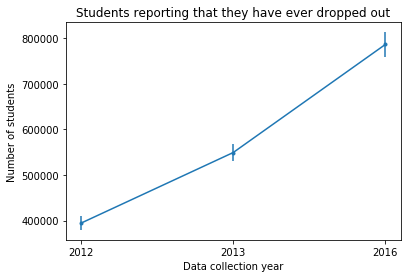

In [14]:
_ = plt.errorbar(x, y, yerr, marker='.')
_ = plt.xlabel('Data collection year')
_ = plt.ylabel('Number of students')
_ = plt.title('Students reporting that they have ever dropped out')
plt.show()